# <center> Обучение с учителем. Классификация. Практика

## <center> Прогнозирование оттока клиентов банка

## Постановка задачи

Теперь настало время самостоятельной работы. В рамках самостоятельной работы вам предстоит решить задачу прогнозирования оттока клиентов банка. 

> **Примечание.** Вы уже знакомились с этой задачей в модуле по визуализации («PYTHON-13. Визуализация данных») и провели небольшое исследование данных. Вы можете использовать результаты своего исследования для построения модели машинного обучения.

Напомним контекст задачи:

> Некоторый банк обратился к вам за помощью: он хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

Итак, ранее вы провели небольшой разведывательный анализ, познакомились с данными и выявили, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов. Вы отлично справились с первой задачей, и теперь представители банка предлагают вам построить саму модель машинного обучения, которая будет прогнозировать отток клиентов. 

**Ваша задача** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

Разделим эту задачу на две части:
* В первой части мы подготовим данные для моделирования и построим простейшую модель логистической регрессии, оценим её качество и проанализируем результаты её работы.

* Во второй части мы займёмся построением моделей дерева решений и случайного леса, сравним их результаты с результатами, полученными на первом этапе, и сделаем финальный вывод.


Для начала импортируем библиотеки, которые нам понадобятся:

In [314]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [315]:
churn_data = pd.read_csv('churn.csv')
churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Практика: логистическая регрессия

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9:

### Задание 5.0 (не оценивается)

Для полноты задачи проведите небольшой разведывательный анализ данных. Постройте графики распределения целевого признака, диаграммы и графики, показывающие взаимосвязь между исходными признаками и целевым признаком, а также другие диаграммы, иллюстрирующие предоставленные данные. 

**Совет:** воспользуйтесь кодом, который вы писали, выполняя задания в модуле «PYTHON-13. Визуализация данных».

Значения столбцов таблицы:

RowNumber — номер строки таблицы;

CustomerId — идентификатор клиента;

Surname — фамилия клиента;

CreditScore — кредитный рейтинг клиента (чем он выше, тем больше клиент брал кредитов и возвращал их);

Geography — страна проживания клиента (банк межнациональный);

Gender — пол клиента;

Age — возраст клиента;

Tenure — сколько лет клиент пользуется банком;

Balance — сколько у клиента денег на счетах в банке;

NumOfProduct — число услуг банка, которыми воспользовался клиент;

HasCrCard — есть ли у клиента кредитная карта (1 — да, 0 — нет);

IsActiveMember — есть ли у клиента статус «активный клиент» (1 — да, 0 — нет);

EstimatedSalary — предполагаемая заработная плата клиента;

Exited — статус ушедшего (1 — ушедший клиент, 0 — лояльный клиент). Целевой признак.

Text(0.5, 1.0, 'Соотношение ушедших и лояльных клиентов')

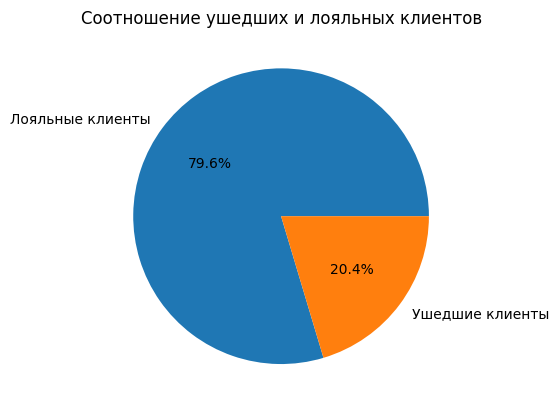

In [316]:
# проверяю сбалансированность классов

round = churn_data['Exited'].value_counts(normalize=True)
fig, ax = plt.subplots()
ax.pie(round, labels= ['Лояльные клиенты', 'Ушедшие клиенты'], autopct='%.1f%%')#создаю диаграмму
ax.set_title('Соотношение ушедших и лояльных клиентов') #подписываю график


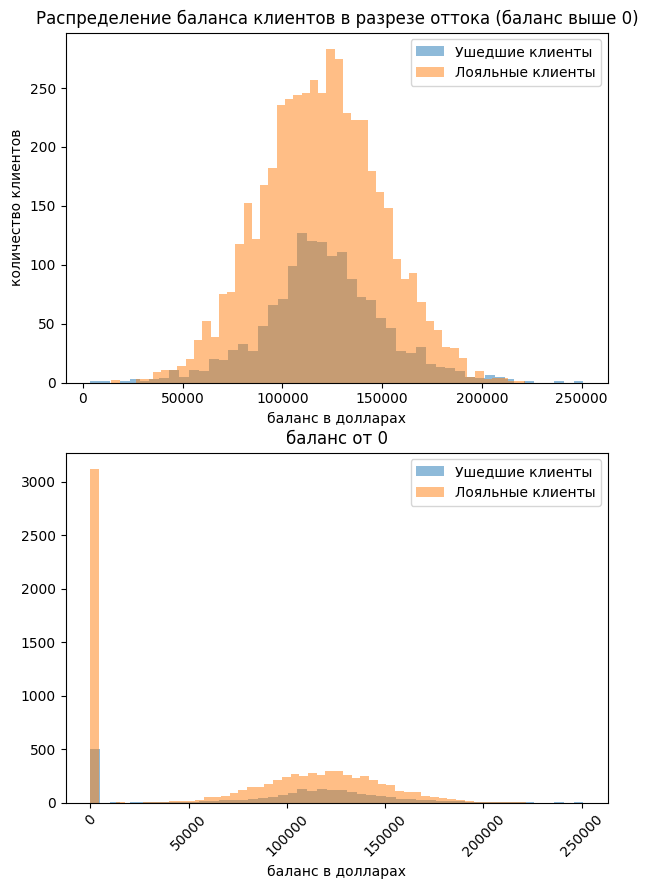

In [317]:
#хочу посмотреть распределение баланса клиентов исключая нулевой баланс и не исключая
balance_outflow = churn_data[churn_data['Balance'] > 0] #фильтрую по балансу
outflow_1, outflow_0 = balance_outflow[balance_outflow['Exited'] == 1], balance_outflow[balance_outflow['Exited'] == 0] #делю клиентов по лояльности
#строю гистограмму для баланса лояльных и ушедших клиентов с фильтрацией баланса
fig, axes = plt.subplots(2, 1, figsize=(7, 10))
axes[0].hist(outflow_1['Balance'], bins = 50, alpha = 0.5)
axes[0].hist(outflow_0['Balance'], bins = 50, alpha = 0.5)
axes[0].set_title('Распределение баланса клиентов в разрезе оттока (баланс выше 0)')#подписываю график и оси
axes[0].set_xlabel('баланс в долларах')
axes[0].set_ylabel('количество клиентов')
axes[0].legend (('Ушедшие клиенты', 'Лояльные клиенты'))

outflow_1_1, outflow_0_1 = churn_data[churn_data['Exited'] == 1], churn_data[churn_data['Exited'] == 0] #делю клиентов по лояльности
axes[1].hist(outflow_1_1['Balance'], bins = 50, alpha = 0.5)
axes[1].hist(outflow_0_1['Balance'], bins = 50, alpha = 0.5)
axes[1].xaxis.set_tick_params(rotation=45)
axes[1].set_xlabel('баланс в долларах')#подписываю график и оси
axes[1].set_title('баланс от 0')
axes[1].legend (('Ушедшие клиенты', 'Лояльные клиенты'))



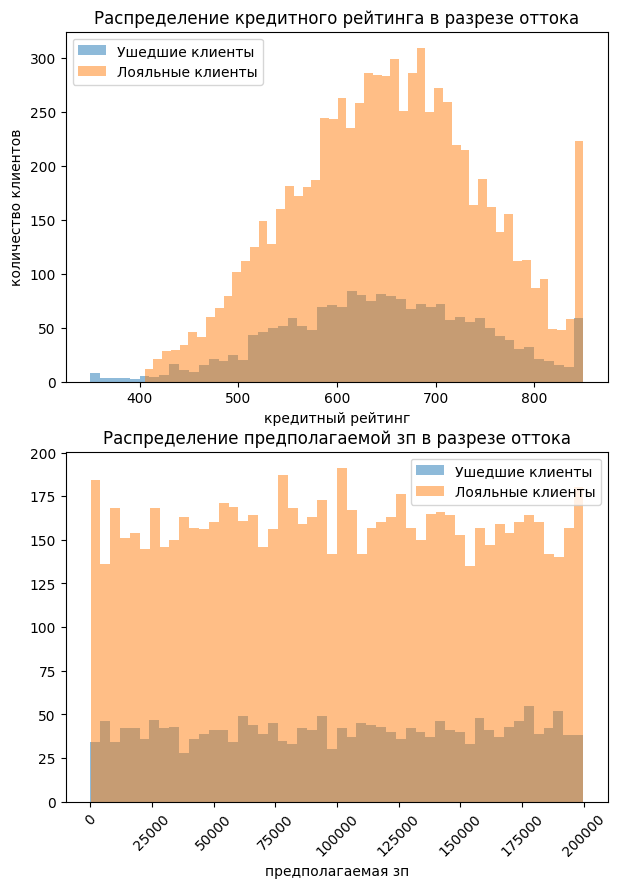

In [318]:
# кредитный рейтинг и предполагаемая зп
outflow_1, outflow_0 = churn_data[churn_data['Exited'] == 1], churn_data[churn_data['Exited'] == 0] #делю клиентов по лояльности

fig, axes = plt.subplots(2, 1, figsize=(7, 10))
axes[0].hist(outflow_1['CreditScore'], bins = 50, alpha = 0.5)
axes[0].hist(outflow_0['CreditScore'], bins = 50, alpha = 0.5)
axes[0].set_title('Распределение кредитного рейтинга в разрезе оттока')#подписываю график и оси
axes[0].set_xlabel('кредитный рейтинг')
axes[0].set_ylabel('количество клиентов')
axes[0].legend (('Ушедшие клиенты', 'Лояльные клиенты'))

axes[1].hist(outflow_1['EstimatedSalary'], bins = 50, alpha = 0.5)
axes[1].hist(outflow_0['EstimatedSalary'], bins = 50, alpha = 0.5)
axes[1].xaxis.set_tick_params(rotation=45)
axes[1].set_xlabel('предполагаемая зп')#подписываю график и оси
axes[1].set_title('Распределение предполагаемой зп в разрезе оттока')
axes[1].legend (('Ушедшие клиенты', 'Лояльные клиенты'))


In [319]:
# построю тепловую картограмму по оттоку клиентов в зависимости от страны
import plotly.express as px

extited_map = churn_data.copy()
extited_map_df = extited_map.groupby(by='Geography',as_index=False)['Exited', 'CustomerId'].agg({'Exited': 'sum', 'CustomerId': 'count'})
#Группирую по странам в разрезе лояльности, добавляю столбец с ID клиента, чтобы впоследствии посчитать общее кол-во
extited_map_df.rename(columns=({'CustomerId': 'Clients'}), inplace=True)#переименовываю столбец для наглядности
extited_map_df['ex_percent'] = ((extited_map_df['Exited']/extited_map_df['Clients'])*100).round(1)
#добавляю столбец с процентом ушедших клиентов

fig_map = px.choropleth(#строю график
    data_frame=extited_map_df, 
    locations="Geography", 
    locationmode = "country names", 
    color= 'ex_percent', 
    range_color=[0, 40], 
    title='Количество ушедших клиентов в разрезе стран', 
    width=800, 
    height=500,
    color_continuous_scale='Blues',       
    fitbounds='locations',
    scope='europe',
)
fig_map.add_scattergeo(#настраиваю информативность графика
    locations = extited_map_df.Geography,
    locationmode = "country names",
    customdata = np.stack((extited_map_df.Clients, extited_map_df.ex_percent), axis=-1), 
    text = extited_map_df.Geography,
    texttemplate='<b style="color: #3C0048; font-size:12px;">%{text}</b>'
                 '<br>%{customdata[0]}'
                 '<br>%{customdata[1]}%',
    hoverinfo = 'skip', 
    mode = 'text'
)
fig_map.show()

C:\Users\Администратор\AppData\Local\Temp\ipykernel_6348\2237364122.py:5: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



<AxesSubplot: xlabel='NumOfProducts', ylabel='Exited'>

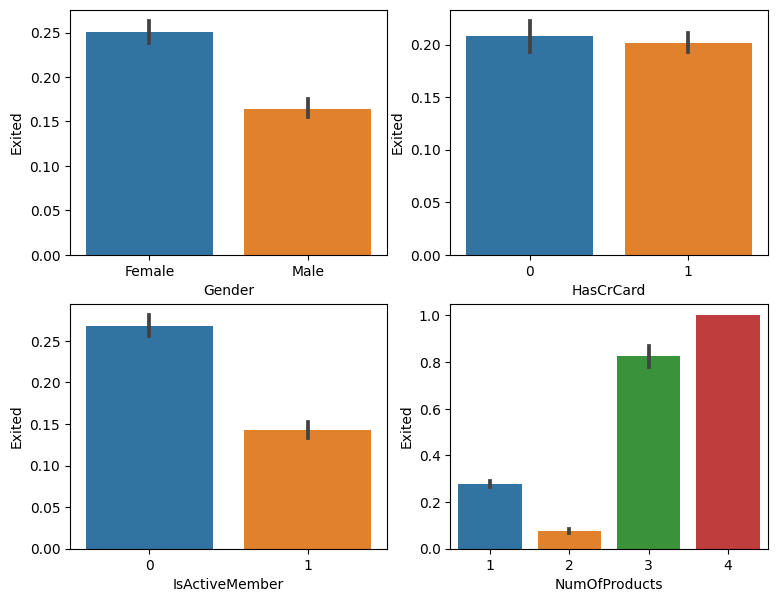

In [320]:
# исследую другие категориальные признаки
# Строю столбчатую диаграмму доли ушедших (среднее по столбцу Exited) в зависимости от категории

fig, axes = plt.subplots(2, 2, figsize=(9, 7))
sns.barplot(data = churn_data, x = 'Gender', y = 'Exited', ax=axes[0][0])
sns.barplot(data = churn_data, x = 'HasCrCard', y = 'Exited', ax=axes[0][1])
sns.barplot(data = churn_data, x = 'IsActiveMember', y = 'Exited', ax=axes[1][0])
sns.barplot(data = churn_data, x = 'NumOfProducts', y = 'Exited', ax=axes[1][1])

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [321]:
churn_data = churn_data[churn_data['Geography'] == 'Germany']
churn_data.shape

(2509, 14)

Сразу избавимся от заведомо неинформативных признаков: страна, номер строки, идентификатор пользователя и имя клиента.

In [322]:
churn_data = churn_data.drop(['Geography', 'RowNumber', 'CustomerId', 'Surname'], axis=1)
churn_data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет пропусков:

In [323]:
churn_data.isnull().sum()

CreditScore        0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

Проверим, что в наших данных нет дубликатов:

In [324]:
churn_data[churn_data.duplicated()].sum()

CreditScore        0.0
Gender             0.0
Age                0.0
Tenure             0.0
Balance            0.0
NumOfProducts      0.0
HasCrCard          0.0
IsActiveMember     0.0
EstimatedSalary    0.0
Exited             0.0
dtype: float64

### Задание 5.1 (1 балл)

Давайте сделаем предобработку данных. 

Для начала расширим датасет с помощью методов Feature Engineering. Создайте следующие признаки:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируйте оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведите основные статистические характеристики полученных признаков.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания указанных в задании признаков;
    * приведён код для кодирования категориальных признаков в числовые бинарные столбцы;
    * приведён код для расчёта основных статистических характеристик полученных признаков.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [325]:
# создаю новые признаки
import category_encoders as ce

# создаю новые признаки
churn_data['BalanceSalaryRatio'] = churn_data['Balance'] / churn_data['EstimatedSalary']
churn_data['TenureByAge'] = churn_data['Tenure'] / churn_data['Age']
churn_data['CreditScoreGivenAge'] = churn_data['CreditScore'] / churn_data['Age']

# кодирую текстовые категориальные признаки
churn_data = pd.get_dummies(churn_data, drop_first=True)
# вывожу стат характеристики
churn_data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,Gender_Male
count,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.00000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000,2509.000000
mean,651.453567,39.771622,5.009964,119730.116134,1.519729,0.71383,0.497409,101113.435102,0.324432,9.024870,0.134303,17.526487,0.524512
std,98.168937,10.519143,2.935154,27022.006157,0.619420,0.45206,0.500093,58263.011501,0.468256,214.286020,0.087680,5.349558,0.499498
min,350.000000,18.000000,0.000000,27288.430000,1.000000,0.00000,0.000000,11.580000,0.000000,0.192582,0.000000,6.112676,0.000000
25%,584.000000,32.000000,2.000000,102800.720000,1.000000,0.00000,0.000000,51016.020000,0.000000,0.783284,0.060606,13.686275,0.000000
50%,651.000000,38.000000,5.000000,119703.100000,1.000000,1.00000,0.000000,102397.220000,0.000000,1.197220,0.125000,16.857143,1.000000
75%,722.000000,45.000000,8.000000,137560.380000,2.000000,1.00000,1.000000,151083.800000,1.000000,2.400083,0.200000,20.852941,1.000000
max,850.000000,84.000000,10.000000,214346.960000,4.000000,1.00000,1.000000,199970.740000,1.000000,10614.655440,0.500000,46.388889,1.000000


Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [326]:
X = churn_data.drop("Exited", axis=1)
y = churn_data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [327]:
y.value_counts(normalize=True)

0    0.675568
1    0.324432
Name: Exited, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 

Функция `train_test_split()` из библиотеки `sklearn` умеет производить такое разбиение. Для этого в ней предусмотрен параметр `stratify`, который нужно выставить в значение признака, который должен иметь одинаковые соотношения в тренировочной и тестовой выборке. У нас этот признак - это целевой признак y. 

Выполним разбиение, установив значение параметра `random_state` на 0:


In [328]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [329]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


0    0.675704
1    0.324296
Name: Exited, dtype: float64



Test :


0    0.675159
1    0.324841
Name: Exited, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу.

### Задание 5.2 (1 балл)

Позаботьтесь о масштабировании признаков. Проведите нормализацию/стандартизацию матрицы наблюдений `X` с помощью `MinMaxScaler`/`RobustScaler` или `StandardScaler`. Выберите метод самостоятельно.

Обучите один из предложенных скейлеров на тренировочной выборке (вычислите параметры трансформации) и примените трансформацию данных к тренировочной и тестовой выборкам.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для создания одного из вариантов скейлеров для масштабирования данных;
    * приведён код для расчёта параметров трансформации (обучение скейлера) на тренировочной выборке;
    * приведён код для трансформации тренировочных и тестовых данных (признаков) в соответствии с вычисленными параметрами.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [330]:
scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### Задание 5.3 (1 балл)

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.

Какую метрику в данной задаче вы будете пытаться улучшить? Обоснуйте свой выбор. 


Ответ:

Необходимо выбрать F-меру, т.к. она сбалансирована между минимизацией ложноположительных и ложноотрицательных срабатываний. А как раз это и необходимо в нашей задаче.

Метрики precision и recall направлены как раз на то, чтобы минимизировать ошибку 1го и 2го рода (соответственно) и увеличение одной из метрик, может привести к уменьшению другой. 

Это нам не подходит.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * выбрана верная метрика;
    * приведено развернутое обоснование выбора метрики, и приведенные рассуждения являются верными;

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

### Задание 5.4 (2 балла)

Обучите модель логистической регрессии (`Logistic Regression`) на тренировочных данных. Позаботьтесь о воспроизводимости результата, установив конкретное значение параметра `random_state` (например, число 42).

Сделайте предсказание меток классов для тренировочной и тестовой выборок. 

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках. 

Проинтерпретируйте полученные результаты, ответив на следующий вопрос:
* Как вы считаете, является ли ваша модель переобученной или недообученной?

> **Примечание.** Будем считать, что модель нас не удовлетворяет (считается недообученной), если значение целевой метрики на тестовой выборке меньше 0.5.

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель логистической регрессии, решающая поставленную задачу;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [331]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    random_state=42 #генератор случайных чисел
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print('F1 на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred)).round(2))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print('F1 на тестовой выборке', (metrics.f1_score(y_test, y_test_pred)).round(2))

F1 на тренировочной выборке 0.51
F1 на тестовой выборке 0.5


По условиям задания, модель будем считать недообученной, если результаты метрики на тестовой выборке меньше 0.5

У меня F-мера на тестовой выборке - 0.5 (не считаем модель недообученной, но и результат можно улучшить)

In [344]:
# пробую управлять параметрами модели
# Создаем объект класса логистическая регрессия
log_reg2 = linear_model.LogisticRegression(
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость 
    penalty  = 'l2', #метод регуляризации
    C = 1, # коэффициент обратный коэффициенту регуляризации
    solver  = 'liblinear' # численный метод оптимизации функции потерь logloss
)
#Обучаем модель, минимизируя logloss
log_reg2.fit(X_train_scaled, y_train)

#Делаем предсказание для тренировочной выборки
y_train_pred2 = log_reg2.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print('Разница F1 с предыдущей моделью на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred2) -  metrics.f1_score(y_train, y_train_pred)).round(4))
#Делаем предсказание для тестовой выборки
y_test_pred2 = log_reg2.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print('Разница F1 с предыдущей моделью на тестовой выборке', metrics.f1_score(y_test, y_test_pred2) - metrics.f1_score(y_test, y_test_pred))


Разница F1 с предыдущей моделью на тренировочной выборке 0.0019
Разница F1 с предыдущей моделью на тестовой выборке 0.0


Подбирая параметры С и penalty, я пришла к следующим выводам:

1) параметр С при увеличении показателя выше 1 и уменьшению ниже 1 - ухудшал метрику F1 на тестовой выборке. оптимальный для него показатель оказался 1

2) параметр penalty по умолчанию выставлен на l2. При попытке его изменить, программа выдавала ошибку "Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.".

Из-за этой ошибки я поняла, что попробовать метод регуляризации l1, я могу, только если буду управлять параметром "solver" (численный метод оптимизации функции потерь logloss). Что я и сделала.

Оказалось, что самые лучшие приросты к показателью F1, по сравнению с предыдущей моделью дают solver = liblinear, penalty  = 'l2' и C = 1.

Надеюсь, что изменение параметра solver не будет считаться ошибкой при проверке работы, задача была улучшить модель, это я и постаралась выполнить.

### Задание 5.5 (2 балла)

Сгенерируйте полиномиальные признаки третьей степени для тренировочной и тестовой выборок. Используйте класс `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` выставите в значение `False`.

> **Примечание.** Обратите внимание, что для генерации полиномов необходимо использовать масштабированные данные.

Обучите модель логистической регрессии на полиномиальных признаках (`Logistic Regression`). Позаботьтесь о воспроизводимости результат, установив конкретное значение параметра `random_state` (например, число 42).

Предскажите метки классов для тренировочной и тестовой выборок.

Рассчитайте значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.

Сравните результат с полученным ранее. Удалось ли вам улучшить качество вашей модели?

**Дополнительное задание:**

Попробуйте поуправлять следующими параметрами модели:
* `penalty` — тип используемой регуляризации ('l1' — $L_1$-регуляризация, 'l2' — $L_2$-регуляризация);
* `C` — коэффициент, обратный коэффициенту регуляризации (по умолчанию он равен 1).

Понаблюдайте, как ведут себя метрики в зависимости от типа регуляризации и увеличения/уменьшения значения парамера `C`.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * сгенерированы полиномиальные признаки третьей степени;
    * построена модель логистической регрессии, решающая поставленную задачу на основе сгенерированных признаков;
    * с помощью полученной модели сформированы предсказания на тренировочной и тестовой выборках;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [345]:
#Создаем объект для генерации полиномиальных признаков степени 3
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

# Создаем объект класса логистическая регрессия
lr_poly = linear_model.LogisticRegression(
    random_state=42
)

lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказания
y_train_pred_poly = lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly = lr_poly.predict(X_test_scaled_poly)

#Вывод отчет о метриках классификации
print('Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred_poly) - metrics.f1_score(y_train, y_train_pred2)).round(3))
print('Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке', (metrics.f1_score(y_test, y_test_pred_poly) - metrics.f1_score(y_test, y_test_pred2)).round(3))



Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке -0.11
Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке -0.093


c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [359]:
# пробую управлять параметрами модели С и penalty, как в задании (подбирала множество вариаций)
# Создаем объект класса логистическая регрессия
lr_poly2 = linear_model.LogisticRegression(
    random_state=42,
    C = 0.001, # коэффициент обратный коэффициенту регуляризации
    penalty  = 'l2', #метод регуляризации 
)

lr_poly2.fit(X_train_scaled_poly, y_train)
#Делаем предсказания
y_train_pred_poly2 = lr_poly2.predict(X_train_scaled_poly)
y_test_pred_poly2 = lr_poly2.predict(X_test_scaled_poly)

#Вывод отчет о метриках классификации
print('Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred_poly2) - metrics.f1_score(y_train, y_train_pred2)).round(3))
print('Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке', (metrics.f1_score(y_test, y_test_pred_poly2) - metrics.f1_score(y_test, y_test_pred2)).round(3))


Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке -0.085
Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке -0.077


In [360]:
# попробую ещё подобрать параметр solver и подобрать степень полиноминальных признаков (подбирала множество вариаций)
# Создаю объект для генерации полиномиальных признаков степени 2
poly3 = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly3.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly3.transform(X_train_scaled)
X_test_scaled_poly = poly3.transform(X_test_scaled)
# Создаем объект класса логистическая регрессия
lr_poly3 = linear_model.LogisticRegression(
    random_state=42,
    C = 6, # коэффициент обратный коэффициенту регуляризации
    penalty  = 'l1', #метод регуляризации
    solver  = 'liblinear' # численный метод оптимизации функции потерь logloss
)

lr_poly3.fit(X_train_scaled_poly, y_train)
#Делаем предсказания
y_train_pred_poly3 = lr_poly3.predict(X_train_scaled_poly)
y_test_pred_poly3 = lr_poly3.predict(X_test_scaled_poly)

#Вывод отчет о метриках классификации
print('Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred_poly3) - metrics.f1_score(y_train, y_train_pred2)).round(2))
print('Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке', (metrics.f1_score(y_test, y_test_pred_poly3) - metrics.f1_score(y_test, y_test_pred2)).round(2))


Разница F1 с предыдущей моделью (log_reg2) на тренировочной выборке 0.2
Разница F1 с предыдущей моделью (log_reg2) на тестовой выборке 0.18


c:\Users\Администратор\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [361]:
print('Итоговая лучшая модель (lr_poly3) имеет метрику F1 на тренировочной выборке', (metrics.f1_score(y_train, y_train_pred_poly3)).round(2), 
      ', на тестовой выборке - ' , (metrics.f1_score(y_test, y_test_pred_poly3)).round(2))


Итоговая лучшая модель (lr_poly3) имеет метрику F1 на тренировочной выборке 0.71 , на тестовой выборке -  0.67


Выводы: 

1) Генерация полиномиальных признаков третьей степени для тренировочной и тестовой выборок и обучение на них модели не привело к улучшению метрики F1.

2) После того как я поуправляла параметрами LogisticRegression пришла к следующему заключению: 

Лучшие значения F1 сравниваемых моделей получается при параметрах - C = 6, solver  = 'liblinear' и penalty  = 'l1'. 

А так же, необходимо генерировать полиномиальные признаки второй степени (надеюсь, что изменение степени не будет являться ошибкой, тк, в задании это не было предложено).

Итоговая лучшая модель (lr_poly3)

### Задание 5.6. (2 балла)


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используйте логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список.

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните результат с полученными ранее.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для построения графика зависимости значения выбранной метрики от порога вероятности;
    * найден оптимальный порог вероятности, на котором достигается наибольшее значение выбранной метрики на тестовой выборке;
    * на основе найденного порога вероятности построено предсказание модели для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не приведён вывод по полученным результатам или вывод является неверным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

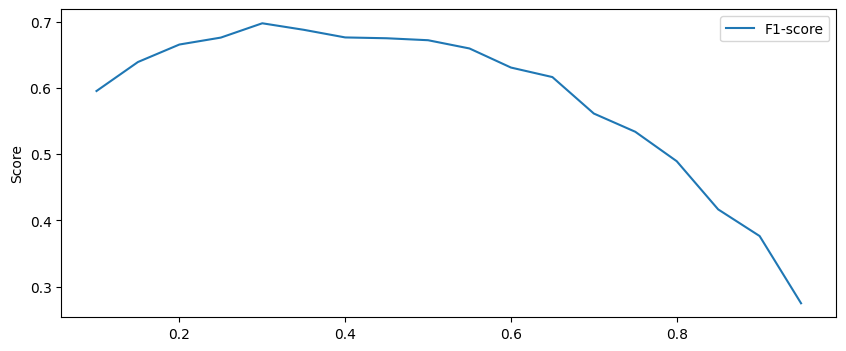

In [362]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(lr_poly3.predict_proba(X_test_scaled_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_test_pred_poly)
    # Добавляем результат в список
    scores.append(score)
    
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_ylabel('Score')
ax.legend();

In [363]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.3
#Людей, у которых вероятность уйти из банка больше 0.3 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('Значение метрики F1 на тестовой выборке', (metrics.f1_score(y_test, y_test_pred_opt).round(2)))
print('Разница F1 с предыдущей лучшей моделью на тестовой выборке', (metrics.f1_score(y_test, y_test_pred_opt) - metrics.f1_score(y_test, y_test_pred_poly3)).round(2))

Значение метрики F1 на тестовой выборке 0.7
Разница F1 с предыдущей лучшей моделью на тестовой выборке 0.03


## Практика: деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Ранее мы построили модель логистической регрессии, затем добавили в модель полиномиальные признаки и подобрали оптимальный порог вероятности для логистической регрессии.

> Теперь попробуем решить задачу с помощью деревьев решений и лесов.


> **Примечание №1.** Для выполнения дальнейших заданий необходимо совершить уже знакомые шаги предобработки с данными об оттоке клиентов банка, а именно:
* выделить данные, относящиеся к отделениям банка в Германии;
* избавиться от заведомо неинформативных признаков;
* расширить датасет путём добавления новых признаков;
* разделить выборку на тренировочную и тестовую со стратификацией.

> **Примечание №2.** Деревья решений — алгоритм, способный уловить нелинейные зависимости. Генерация полиномиальных признаков практически не имеет значения.
Также деревья решений не чувствительны к масштабу признаков. Масштабирование исходных данных не играет роли при построении деревьев решения.
Поэтому для решения задачи используйте обучающую (`X_train`, `y_train`) и тестовую (`X_test`, `y_test`) выборки без полиномиальных столбцов.


In [364]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [365]:
from sklearn import tree
from sklearn import ensemble

Приступим! Выполните задания 8.1–8.4.

### Задание 8.1. (2 балла)

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с неограниченной максимальной глубиной дерева. В качестве критерия информативности используйте энтропию Шеннона, остальные параметры оставьте по умолчанию. 

Также позаботьтесь о воспроизводимости результатов, установив конкретное  значение `random_state` (например, число 42). 

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сделайте вывод, ответив на вопрос:
* Как вы считаете, является полученная модель переобученной или недообученной? Попробуйте дать обоснование, почему так происходит.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос, а также обоснование полученного результата.

- Задание выполнено верно, но не приведено обоснование полученного результата или обоснование является некорректным (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [366]:
#Создаём объект класса DecisionTreeClassifier
model_tree = tree.DecisionTreeClassifier(
    criterion='entropy',#критерий эффективности
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
model_tree.fit(X_train, y_train)


#Делаем предсказание на тренировочных данных
y_pred = model_tree.predict(X_train)
#Выводим отчёт о метриках
print('Значение метрики F1 на тренировочной выборке', metrics.f1_score(y_train, y_pred))
#Делаем предсказание на тестовых данных
y_pred_test = model_tree.predict(X_test)
#Выводим отчёт о метриках
print('Значение метрики F1 на тестовой выборке', (metrics.f1_score(y_test, y_pred_test)).round(2))



Значение метрики F1 на тренировочной выборке 1.0
Значение метрики F1 на тестовой выборке 0.53


Вывод:

Модель переобучена. Об этом говорит нам единица по метрике в тестовой выборке.

Я думаю, что это произошло из-за того, что мы не задали дополнительные параметры в модель. Необходимо добавить максимальную глубину и минимальное количество объектов в листе.

Тогда модель не будет идеально подстраиваться под параметры обучающей выборки (создавать очень глубокое дерево) и мы можем исключить её переобучение.

### Задание 8.2. (1 балл)

Давайте «подстрижём» наше дерево. 

Обучите на тренировочной выборке дерево решений из библиотеки `sklearn` (`DecisionTreeClassifier`) с максимальной глубиной 8. В качестве критерия информативности используйте энтропию Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните результат с полученными ранее. Сделайте вывод.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балла**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [367]:
#Создаём объект класса DecisionTreeClassifier
model_tree2 = tree.DecisionTreeClassifier(
    criterion='entropy',#критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель по алгоритму CART
model_tree2.fit(X_train, y_train)


#Делаем предсказание на тренировочных данных
y_pred2 = model_tree2.predict(X_train)
#Выводим отчёт о метриках
print('Значение метрики F1 на тренировочной выборке', metrics.f1_score(y_train, y_pred2).round(2))
#Делаем предсказание на тестовых данных
y_pred_test2 = model_tree2.predict(X_test)
#Выводим отчёт о метриках
print('Значение метрики F1 на тестовой выборке', metrics.f1_score(y_test, y_pred_test2).round(2))



Значение метрики F1 на тренировочной выборке 0.72
Значение метрики F1 на тестовой выборке 0.65


Вывод:

После добавления дополнительных параметров в модель, результаты метрик стали значительно лучше.

Модель не переобучена, об этом нам говорит значение метрики  F1 на тренировочной выборке 0.72

### Задание 8.3. (1 балл)

Давайте воспользуемся случайным лесом. 

Постройте случайный лес (`RandomForestClassifier`) из 500 деревьев с максимальной глубиной 8. Критерий информативности — энтропия Шеннона, минимальное число объектов в листе (количество объектов, при которых дерево прекратит делиться и образуется лист) — 10.

Также позаботьтесь о воспроизводимости результатов, установив конкретное значение значение `random_state` (например, число 42).

Сделайте предсказания для тренировочной и тестовой выборок. Рассчитайте значение целевой метрики на каждой из выборок.

Сравните качество одного дерева решений с качеством случайного леса на тестовой выборке. Смогли ли вы улучшить метрику?


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * построена модель дерева решений с заданными в условии задачи параметрами;
    * с помощью полученной модели сформированы предсказания для тренировочной и тестовой выборок;
    * приведён расчёт выбранной метрики на тренировочных и тестовых данных (метрика должна быть выбрана корректно);
    * приведён небольшой вывод по полученным результатам, в котором содержится корректный ответ на поставленный в задании вопрос.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [368]:
#Создаем объект класса случайный лес
rand_forest = ensemble.RandomForestClassifier(
    n_estimators=500, #количество деревьев
    max_depth=8,#максимальная глубина дерева
    criterion='entropy',#критерий эффективности
    min_samples_leaf=10, # минимальное число объектов в листе
    random_state=42 #генератор случайных чисел
)

#Обучаем модель
rand_forest.fit(X_train, y_train)
#Делаем предсказание на тренировочных данных
y_pred3 = rand_forest.predict(X_train)
#Выводим отчёт о метриках
print('Значение метрики F1 на тренировочной выборке', metrics.f1_score(y_train, y_pred3).round(2))
#Делаем предсказание на тестовых данных
y_pred_test3 = rand_forest.predict(X_test)
#Выводим отчёт о метриках
print('Значение метрики F1 на тестовой выборке', metrics.f1_score(y_test, y_pred_test3).round(2))

Значение метрики F1 на тренировочной выборке 0.73
Значение метрики F1 на тестовой выборке 0.64


Вывод:

Нет, я не смогла улучшить метрики. F1 стала ненамного, но ниже, на 0.01. 

Значит модель не стала лучше.

### Задание 8.4. (2 балла)

Мы на финишной прямой. 


Попробуйте подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. **Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке.**


В качестве порога вероятности используйте значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`

Напомним алгоритм, как определить оптимальный порог вероятности:
* Предсказать вероятности оттока для каждого клиента из тестовой выборки.
* В цикле перебрать значения порогов вероятности threshold:
    * Сделать предсказание класса по принципу: если вероятность > threshold, то отнести объект к классу 1, в противном случае — к классу 0.
    * Рассчитать метрику и занести её в заранее созданный список. 

Для реализации алгоритма подбора вы можете воспользоваться шаблоном кода, приведённым ниже:

```python
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model.predict_proba(X_test_poly)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = # код для вычисления метрики
    # Добавляем результат в список
    scores.append(score)
```

Постройте график зависимости целевой метрики от порога вероятности. На основе построенного графика определите порог вероятности, которому соответствует наибольшее значение целевой метрики на тестовой выборке.

Сделайте предсказание классов с подобранным оптимальным порогом вероятности. Рассчитайте значение целевой метрики на тестовой выборке и сравните полученный результат с полученными ранее. 

Напишите небольшой вывод о проделанной работе, указав в нём, какая из рассмотренных нами моделей показала наилучший результат.

> **Примечание.** Помните о том, что в реальных задачах (а мы решали задачу на реальных данных) мы практически никогда не сможем получить значения метрик, близкие к 1. Если в задаче прогнозирования оттока ваша метрика превышает хотя бы значения 0.6-0.7, вашу модель уже можно считать хорошей и можно говорить о том, что она успешно справляется с задачей.

метрика F1 после изменения порога вероятностей 0.65


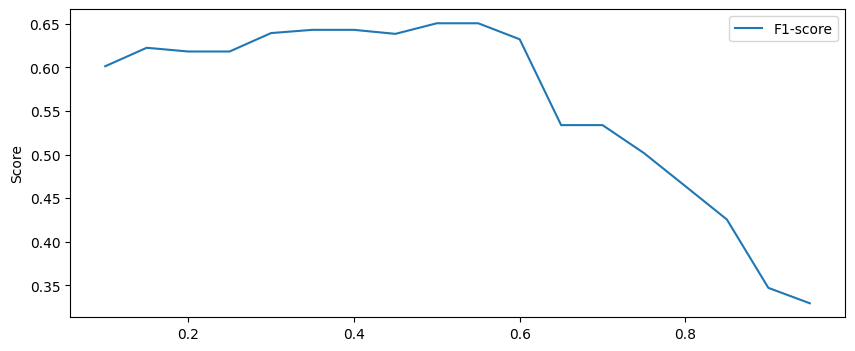

In [369]:
# Делаем предсказание вероятности оттока для каждого клиента из тестовой выборки
y_test_proba_pred = pd.Series(model_tree2.predict_proba(X_test)[:, 1])
# Инициализируем список, куда будем сохранять метрики.
scores = []
# Задаём значения порогов вероятности
thresholds = np.arange(0.1, 1, 0.05)
# В цикле перебираем значения порогов вероятности
for threshold in thresholds:
    # Делаем предсказание
    y_pred_test = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0)
    # Рассчитываем метрику
    score = metrics.f1_score(y_test, y_pred_test)
    # Добавляем результат в список
    scores.append(score)
    
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_ylabel('Score')
ax.legend();

#Задаем оптимальный порог вероятностей
threshold_opt = 0.55
#Людей, у которых вероятность уйти больше 0.55 относим к классу 1
#В противном случае - к классу 0
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print('метрика F1 после изменения порога вероятностей' , metrics.f1_score(y_test, y_test_pred_opt).round(2))

Вывод:

Подобрав порог вероятности чуть выше, не удалось улучшить метрику F1. Порог вероятности по умолчанию и до 0.55 - оптимальный для лучшей метрики на деревьях решений.

P.s. в задании указано: "Используйте ту модель (из рассмотренных ранее), которая показала наилучшее качество на тестовой выборке". 

Не совсем понятно, имеется вввиду ВСЕ модели, рассмотренные ранее, или ТОЛЬКО в блоке деревьев решений.

Я выполнила задание из блока деревьев решений, но если имелось ввиду ВСЕ модели, то чуть выше (в задании 5.6), я выполнила это на модели lr_poly3 (она лучшая во всей моей работе)

### Задание 8.5. (1 балл)

Наконец, финальная задача.

У нашего банка есть некоторый клиент, назовём его Василием. В базе данных банка хранятся следующие данные о Василии:

```python
{
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}
```

С помощью наилучшей модели спрогнозируйте вероятность того, что Василий откажется от услуг банка.

> **Примечание.** Учтите, что для предсказания необходимо преобразовать данные к тому формату, на котором обучалась модель, то есть:
* добавить признаки дополнительные признаки; 
* произвести кодирование категориальных признаков;
* произвести масштабирование признаков (если ваша модель обучалась на масштабированных данных) с помощью того же скейлера, который вы использовали при обучении модели;
* сгенерировать полиномиальные признаки.

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * сформирован DataFrame на основе предоставленного словаря;
    * произведены преобразования данных, необходимые для работы модели;
    * предсказана вероятность оттока клиента (вероятность принадлежности к классу 1).

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [370]:
vasily = pd.DataFrame({
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
})

# произвожу все манипуляции с данными, что и в тренировочной выборке
vasily['BalanceSalaryRatio'] = vasily['Balance'] / vasily['EstimatedSalary']
vasily['TenureByAge'] = vasily['Tenure'] / vasily['Age']
vasily['CreditScoreGivenAge'] = vasily['CreditScore'] / vasily['Age']

vasily = pd.get_dummies(vasily, drop_first=True)
vasily['Gender_Male'] = 1

scaler = preprocessing.RobustScaler()
scaler.fit(X_train)
vasily_scaled = scaler.transform(X_train)
vasily_scaled = scaler.transform(vasily)

vasily_scaled_poly = poly3.transform(vasily_scaled)


In [371]:
# прогнозирую отток Василия с помощью лучшей модели
vasily_proba = lr_poly3.predict_proba(vasily_scaled_poly)[:, 1]*100
vasily_predict = lr_poly3.predict(vasily_scaled_poly)
print(f'Вероятность оттока клиента: {vasily_proba[0]:.2f}%')
print(f'Модель отнесла клиента к классу: {vasily_predict}')

Вероятность оттока клиента: 72.90%
Модель отнесла клиента к классу: [1]


Вывод:

Василий с вероятностью 73% покинет банк.